In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


Random Seed:  999


In [49]:
# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For out black and white images, this is 1
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 4

In [21]:
from dataset import AugmentedPairedImageDataset

dataset = AugmentedPairedImageDataset('training-repaired', 'training-damaged', seed=manualSeed)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=True)
# Print the effective size of the dataset
print(f"Effective dataset size: {len(dataset)}")

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(device)
real_batch = next(iter(dataloader))
print("hello, world!")

Found 1146 valid image pairs
Effective dataset size: 4584
cuda:0
hello, world!


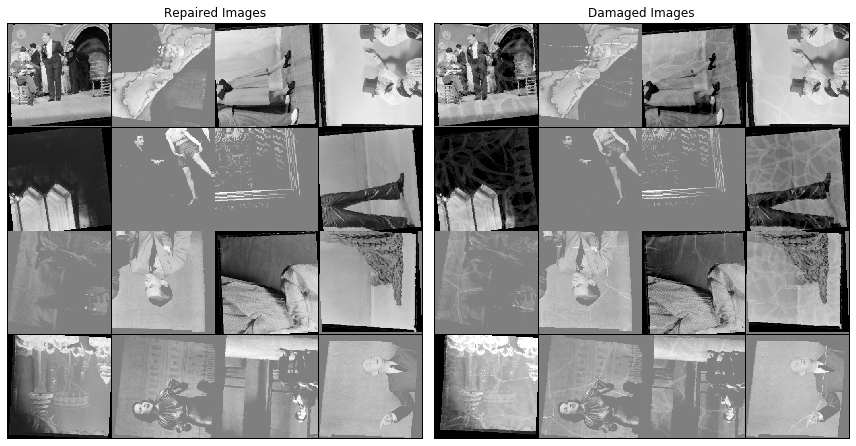

In [22]:
# Show some training images

def show_image_grid(repaired, damaged, device):
    # Ensure we have 16 images of each type (4 rows * 4 columns)
    repaired = repaired[48:64]
    
    damaged = damaged[48:64]


    # Create grids for repaired and damaged images (4 rows each)
    grid_repaired = vutils.make_grid(repaired, nrow=4, padding=2, normalize=True)
    grid_damaged = vutils.make_grid(damaged, nrow=4, padding=2, normalize=True)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    
    # Plot repaired images
    ax1.axis("off")
    ax1.set_title("Repaired Images")
    ax1.imshow(np.transpose(grid_repaired.cpu(), (1, 2, 0)))
    
    # Plot damaged images
    ax2.axis("off")
    ax2.set_title("Damaged Images")
    ax2.imshow(np.transpose(grid_damaged.cpu(), (1, 2, 0)))
    
    plt.tight_layout()
    plt.show()

repaired, damaged = real_batch
show_image_grid(repaired.to(device), damaged.to(device), device)

In [23]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [24]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            # state size. (ngf*32) x 4 x 4
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 8 x 8
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 16 x 16
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 32 x 32
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 64 x 64
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 128 x 128
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

In [25]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), s

In [26]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*32) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [27]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

In [28]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [29]:
def apply_mask(images, masks):
    """
    Apply masks to a batch of images.
    
    Args:
    images: Tensor of shape (batch_size, channels, height, width)
    masks: Tensor of shape (batch_size, 1, height, width)
    
    Returns:
    Tensor of shape (batch_size, channels, height, width)
    """
    # Ensure both tensors are on the same device
    if images.device != masks.device:
        masks = masks.to(images.device)
    
    return images * (1 - masks) + masks

In [50]:
# Constants
dataset_size = 4584
batch_size = 128

# Create fixed noise for visualization
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Training Loop
img_list = []
mask_list = []
G_losses = []
D_losses = []
iters = 0

# Load saved state dictionaries
netG.load_state_dict(torch.load('netG_final.pth', weights_only=True))
netD.load_state_dict(torch.load('netD_final.pth', weights_only=True))

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (undamaged_images, real_damaged_images) in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # format batch, send to device
        undamaged_images, real_damaged_images = undamaged_images.to(device), real_damaged_images.to(device)
        b_size = undamaged_images.size(0)
        
        ## Train with all-real batch
        netD.zero_grad()
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_damaged_images)
        output = output.view(-1)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake mask batch with G
        fake_masks = netG(noise)
        # Ensure the generated masks have the correct shape
        if fake_masks.size(1) != 1:
            fake_masks = fake_masks.mean(dim=1, keepdim=True)
            
        # Apply fake mask for discrimination
        fake = apply_mask(undamaged_images, fake_masks)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_masks = netG(fixed_noise).detach().cpu()
                # Use only the first b_size samples from fixed_noise output
                fake = apply_mask(undamaged_images.cpu(), fake_masks[:b_size])
                mask_list.append(vutils.make_grid(fake_masks[:b_size], padding=2, normalize=True))
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

torch.save(netG.state_dict(), 'netG_final.pth')
torch.save(netD.state_dict(), 'netD_final.pth')

Starting Training Loop...
[0/30][0/36]	Loss_D: 0.2020	Loss_G: 4.2188	D(x): 0.8729	D(G(z)): 0.0231 / 0.0346
[1/30][0/36]	Loss_D: 0.2104	Loss_G: 6.0490	D(x): 0.8788	D(G(z)): 0.0014 / 0.0219
[2/30][0/36]	Loss_D: 0.9052	Loss_G: 3.7304	D(x): 0.6064	D(G(z)): 0.0125 / 0.0841
[3/30][0/36]	Loss_D: 0.7640	Loss_G: 6.7235	D(x): 0.8465	D(G(z)): 0.2932 / 0.0155
[4/30][0/36]	Loss_D: 0.8556	Loss_G: 3.5667	D(x): 0.8733	D(G(z)): 0.3095 / 0.0833
[5/30][0/36]	Loss_D: 0.6377	Loss_G: 2.2711	D(x): 0.7781	D(G(z)): 0.1104 / 0.1941
[6/30][0/36]	Loss_D: 0.7382	Loss_G: 2.0589	D(x): 0.7162	D(G(z)): 0.2234 / 0.2375
[7/30][0/36]	Loss_D: 0.5210	Loss_G: 2.2030	D(x): 0.7087	D(G(z)): 0.0692 / 0.1558
[8/30][0/36]	Loss_D: 1.2375	Loss_G: 3.1662	D(x): 0.9848	D(G(z)): 0.4646 / 0.1453
[9/30][0/36]	Loss_D: 0.9733	Loss_G: 1.9192	D(x): 0.4927	D(G(z)): 0.0067 / 0.2388
[10/30][0/36]	Loss_D: 1.3301	Loss_G: 1.3396	D(x): 0.4165	D(G(z)): 0.0174 / 0.4241
[11/30][0/36]	Loss_D: 0.2062	Loss_G: 3.9902	D(x): 0.9618	D(G(z)): 0.1303 / 0.0613


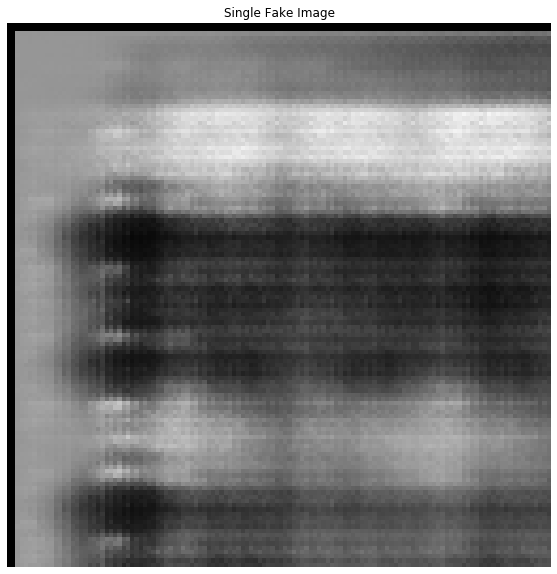

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Plot a single fake image from the last epoch
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Single Fake Image")

# Get the last grid from mask_list
last_grid = mask_list[-1]

# Extract a single image from the grid
single_image = last_grid[:, :128, :128]  # Adjust these dimensions as needed

# Display the single image
plt.imshow(np.transpose(single_image, (1, 2, 0)))
plt.show()